In [3]:
#Importing libraries and loading dataset
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime


dataset = pd.read_csv('preprocessed_dataset_china.csv')                            

In [4]:
dataset.head()

,date_and_time,PM2.5,O3,TEMPERATURE,PRESSURE,DEWPOINT,RAIN
0,3/1/2013 0:00,0.006024,0.172689,0.297909,0.646749,0.255486,0.0
1,3/1/2013 1:00,0.008032,0.183869,0.290941,0.655536,0.250784,0.0
2,3/1/2013 2:00,0.005020,0.164304,0.282230,0.659051,0.244514,0.0
3,3/1/2013 4:00,0.005020,0.100020,0.277003,0.685413,0.213166,0.0
4,3/1/2013 5:00,0.007028,0.178279,0.264808,0.695958,0.222571,0.0


In [5]:
# load dataset
df = pd.read_csv('preprocessed_dataset_china.csv', header=0, index_col=0)
df.describe()

,PM2.5,O3,TEMPERATURE,PRESSURE,DEWPOINT,RAIN
count,33663.000000,33663.000000,33663.000000,33663.000000,33663.000000,33663.000000
mean,0.081787,0.156106,0.533666,0.463514,0.595715,0.001377
std,0.086078,0.159436,0.198664,0.186095,0.216007,0.016916
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.019076,0.021761,0.351916,0.311072,0.418495,0.000000
50%,0.056225,0.116790,0.552265,0.453427,0.606583,0.000000
75%,0.112450,0.228589,0.703833,0.613357,0.793103,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [6]:
dataset_columns = df.columns.tolist()
dataset_columns

['PM2.5', 'O3', 'TEMPERATURE', 'PRESSURE', 'DEWPOINT', 'RAIN']

In [10]:
from sklearn.preprocessing import LabelEncoder

# Encode non categorical values
values = df.values
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
values = values.astype('float32')
values[:,1]

array([304., 316., 292., ..., 265., 292., 239.], dtype=float32)

In [11]:
#Normalising data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_dataset = scaler.fit_transform(values)

In [12]:
#Creating a window for previous data
def to_supervised(train):
  window_size = 2
  X = []
  Y = []
  for i in range(window_size, len(train)):
    X.append(train[i-window_size:i,:])
    Y.append(train[i,0:1])
    
  return X,Y

In [13]:
X, Y = to_supervised(scaled_dataset)
X = np.array(X)
Y = np.array(Y)
print('Y' ,Y.shape)
print('X' ,X.shape)


Y (33661, 1)
X (33661, 2, 6)


In [14]:
# Define training size and validation size
n_train = 24 * 365   # For example, 1 year of data for training
n_val = int(n_train * 0.2)  # Use 20% of the training data for validation (you can adjust the ratio)

# Split the data
X_train, X_test = X[n_train:,], X[:n_train,]
Y_train, Y_test = Y[n_train:,], Y[:n_train,]

# Further split the training data into training and validation sets
X_val, X_train = X_train[:n_val,], X_train[n_val:,]
Y_val, Y_train = Y_train[:n_val,], Y_train[n_val:,]

# Print the shapes to verify
print('X_train', X_train.shape)
print('X_test', X_test.shape)
print('X_val', X_val.shape)

print('Y_train', Y_train.shape)
print('Y_test', Y_test.shape)
print('Y_val', Y_val.shape)

X_train (23149, 2, 6)
X_test (8760, 2, 6)
X_val (1752, 2, 6)
Y_train (23149, 1)
Y_test (8760, 1)
Y_val (1752, 1)


In [15]:
# import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
import keras_tuner as kt
import numpy as np

# Ensure n_steps and n_features are defined
n_steps = X_train.shape[1]  # Define number of time steps
n_features = 6  # Example feature count (update accordingly)

# Define hyperparameter tuning function
def build_model(hp):
    model = Sequential()
    
    # Single LSTM layer with tuning of units
    model.add(LSTM(
        units=hp.Choice('units', [8, 16, 32, 64, 128]),  # Tuning hidden units
        activation='relu',
        input_shape=(n_steps, n_features)
    ))
    
    # Dropout layer with tuning of dropout rate
    model.add(Dropout(hp.Choice('dropout', [0.2, 0.3, 0.4])))  # Tuning dropout rate
    
    # Output layer
    model.add(Dense(1))  # Regression output
    
    # Optimizer Selection with different learning rates
    optimizer_choice = hp.Choice('optimizer', ['SGD', 'Adam', 'RMSprop'])  # Tuning optimizer
    
    if optimizer_choice == 'SGD':
        optimizer = SGD(
            learning_rate=hp.Choice('sgd_lr', [0.01, 0.005, 0.001, 0.0005]),  # Tuning SGD learning rate
            momentum=0.9, nesterov=True
        )
    elif optimizer_choice == 'Adam':
        optimizer = Adam(
            learning_rate=hp.Choice('adam_lr', [0.001, 0.0005, 0.0001, 0.00005])  # Tuning Adam learning rate
        )
    else:  # RMSprop
        optimizer = RMSprop(
            learning_rate=hp.Choice('rmsprop_lr', [0.001, 0.0005, 0.0001, 0.00005]),  # Tuning RMSprop learning rate
            rho=0.9
        )
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    
    return model

# Initialize Keras Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='loss',  # Tuning for minimum loss
    max_trials=10,  # Number of trials for hyperparameter search
    executions_per_trial=1,  # Number of times each trial is executed
    directory='kt_tuning',  # Directory for storing tuning results
    project_name='lstm_aqi_tuning_v2'  # Project name for storing results
)

# Perform Hyperparameter Search (ensure you have validation data like X_split_val, y_split_val)
tuner.search(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val), batch_size=32)

# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Output the best hyperparameters
print(f"""
Best LSTM units: {best_hps.get('units')}
Best Dropout Rate: {best_hps.get('dropout')}
Best Optimizer: {best_hps.get('optimizer')}
Best Learning Rate: {best_hps.get('sgd_lr' if best_hps.get('optimizer') == 'SGD' else 'adam_lr' if best_hps.get('optimizer') == 'Adam' else 'rmsprop_lr')}
""")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, Y_train, epochs=50, validation_data=(X_val, Y_val), batch_size=32)

Reloading Tuner from kt_tuning\lstm_aqi_tuning_v2\tuner0.json

Best LSTM units: 128
Best Dropout Rate: 0.2
Best Optimizer: Adam
Best Learning Rate: 0.0005

Epoch 1/50
724/724 [==============================] - 5s 5ms/step - loss: 0.1957 - mae: 0.2588 - val_loss: 0.0462 - val_mae: 0.1291
Epoch 2/50
724/724 [==============================] - 3s 5ms/step - loss: 0.0902 - mae: 0.1772 - val_loss: 0.0429 - val_mae: 0.1213
Epoch 3/50
724/724 [==============================] - 3s 5ms/step - loss: 0.0799 - mae: 0.1646 - val_loss: 0.0418 - val_mae: 0.1183
Epoch 4/50
724/724 [==============================] - 3s 5ms/step - loss: 0.0769 - mae: 0.1586 - val_loss: 0.0406 - val_mae: 0.1160
Epoch 5/50
724/724 [==============================] - 3s 5ms/step - loss: 0.0771 - mae: 0.1563 - val_loss: 0.0409 - val_mae: 0.1149
Epoch 6/50
724/724 [==============================] - 3s 4ms/step - loss: 0.0739 - mae: 0.1519 - val_loss: 0.0400 - val_mae: 0.1128
Epoch 7/50
724/724 [==============================] 

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Perform Predictions
y_pred = best_model.predict(X_test)

# Compute MSE, MAE, RMSE
mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
r2 = r2_score(Y_test, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"R²: {r2}")

274/274 [==============================] - 1s 3ms/step
RMSE: 0.25912004709243774
MSE: 0.06714320182800293
MAE: 0.15193502604961395
R²: 0.9324228117682445


In [17]:
from sklearn.model_selection import KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_mse, cv_mae, cv_rmse = [], [], []

for train_idx, val_idx in kf.split(X_train):
    X_train_fold, X_val_fold = X_train[train_idx], X_train[val_idx]
    y_train_fold, y_val_fold = Y_train[train_idx], Y_train[val_idx]

    # Train model on fold
    fold_model = tuner.hypermodel.build(best_hps)
    fold_model.fit(X_train_fold, y_train_fold, epochs=50, batch_size=32, verbose=0)

    # Predict
    y_val_pred = fold_model.predict(X_val_fold)

    # Compute Metrics
    fold_mse = mean_squared_error(y_val_fold, y_val_pred)
    fold_mae = mean_absolute_error(y_val_fold, y_val_pred)
    fold_rmse = np.sqrt(fold_mse)

    cv_mse.append(fold_mse)
    cv_mae.append(fold_mae)
    cv_rmse.append(fold_rmse)

# Print Cross Validation Results
# print(f"Cross-Validation MSE: {np.mean(cv_mse)} ± {np.std(cv_mse)}")
# print(f"Cross-Validation MAE: {np.mean(cv_mae)} ± {np.std(cv_mae)}")
# print(f"Cross-Validation RMSE: {np.mean(cv_rmse)} ± {np.std(cv_rmse)}")

print(f"Cross-Validation MSE: {np.mean(cv_mse)} (std: {np.std(cv_mse)})")
print(f"Cross-Validation MAE: {np.mean(cv_mae)} (std: {np.std(cv_mae)})")
print(f"Cross-Validation RMSE: {np.mean(cv_rmse)} (std: {np.std(cv_rmse)})")


145/145 [==============================] - 0s 2ms/step
Cross-Validation MSE: 0.05669887736439705 (std: 0.007070747669786215)
Cross-Validation MAE: 0.12784124910831451 (std: 0.0025352146476507187)
Cross-Validation RMSE: 0.23765647411346436 (std: 0.014774131588637829)


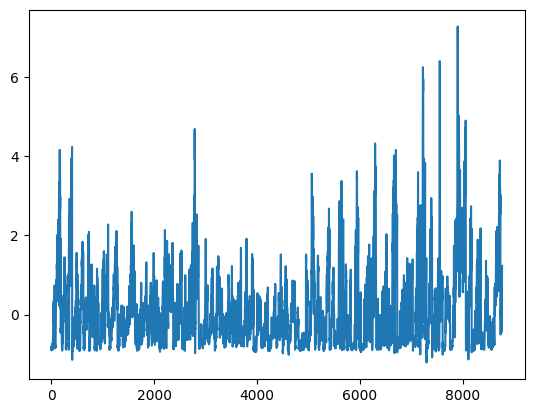

In [18]:
plt.plot(y_pred)

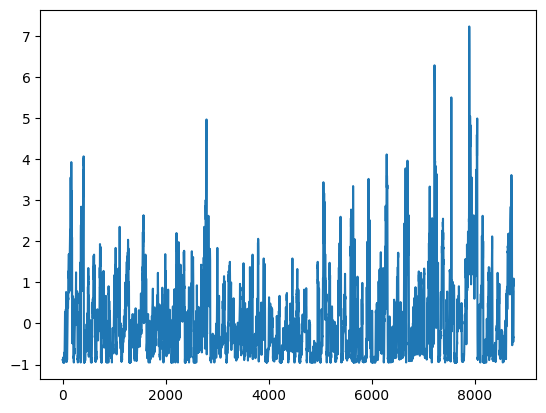

In [19]:
plt.plot(Y_test)

In [20]:
_, train_acc = best_model.evaluate(X_train, Y_train, verbose=0)
_, test_acc = best_model.evaluate(X_test, Y_test, verbose=0)
print('Train: %.5f, Test: %.5f' % (train_acc, test_acc))

Train: 0.12473, Test: 0.15194


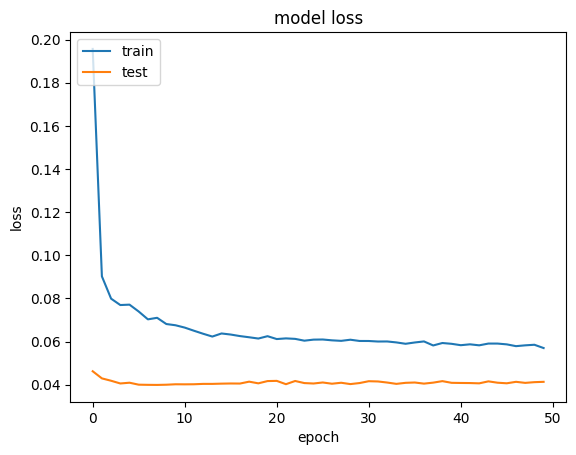

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Epoch-wise validation loss:
Epoch 1: 0.046217627823352814
Epoch 2: 0.04291315749287605
Epoch 3: 0.041815247386693954
Epoch 4: 0.04055461660027504
Epoch 5: 0.040906019508838654
Epoch 6: 0.039993420243263245
Epoch 7: 0.039919570088386536
Epoch 8: 0.03988167271018028
Epoch 9: 0.039975035935640335
Epoch 10: 0.04018111154437065
Epoch 11: 0.04015535116195679
Epoch 12: 0.040189824998378754
Epoch 13: 0.04036179184913635
Epoch 14: 0.040361445397138596
Epoch 15: 0.04047456011176109
Epoch 16: 0.040548693388700485
Epoch 17: 0.04051685705780983
Epoch 18: 0.04139285162091255
Epoch 19: 0.04061644524335861
Epoch 20: 0.04166411980986595
Epoch 21: 0.04175885021686554
Epoch 22: 0.04021899774670601
Epoch 23: 0.04170510172843933
Epoch 24: 0.04073738679289818
Epoch 25: 0.040538761764764786
Epoch 26: 0.04101245850324631
Epoch 27: 0.040439166128635406
Epoch 28: 0.04088721424341202
Epoch 29: 0.04026859253644943
Epoch 30: 0.04074910655617714
Epoch 31: 0.04160194471478462
Epoch 32: 0.04148571193218231
Epoch 33: 

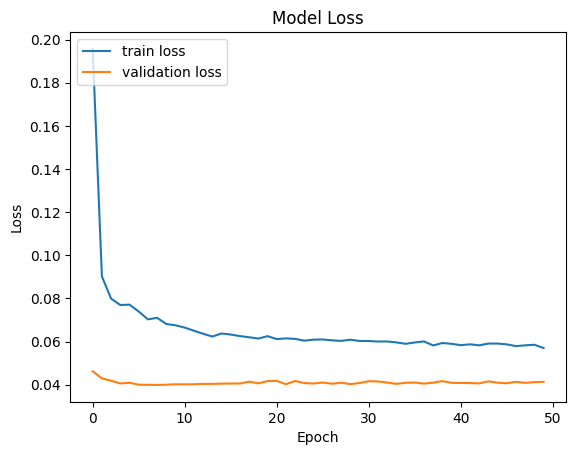

In [22]:
# Print validation loss at each epoch
print("Epoch-wise validation loss:")
for epoch, val_loss in enumerate(history.history['val_loss']):
    print(f"Epoch {epoch+1}: {val_loss}")

# Plotting the loss graph
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()


In [23]:
from numpy import array
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X),array(y)

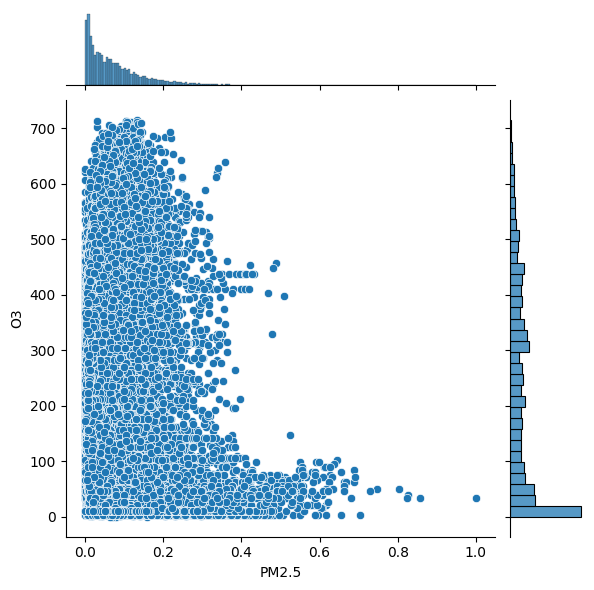

In [24]:
import seaborn as sns
sns.jointplot(x=df['PM2.5'], y=df['O3'], data = df)

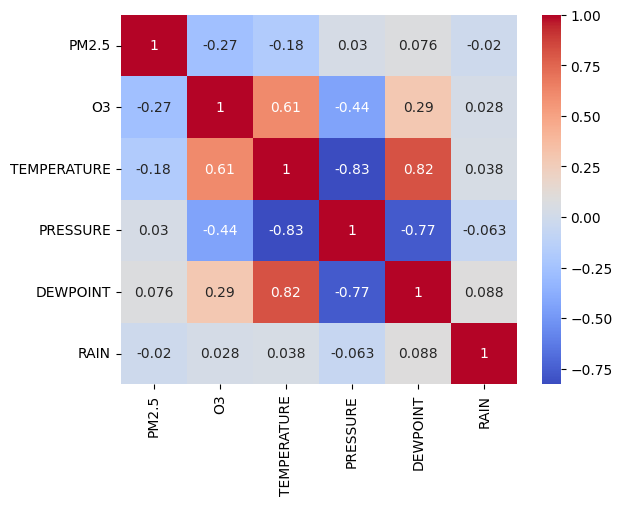

In [25]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

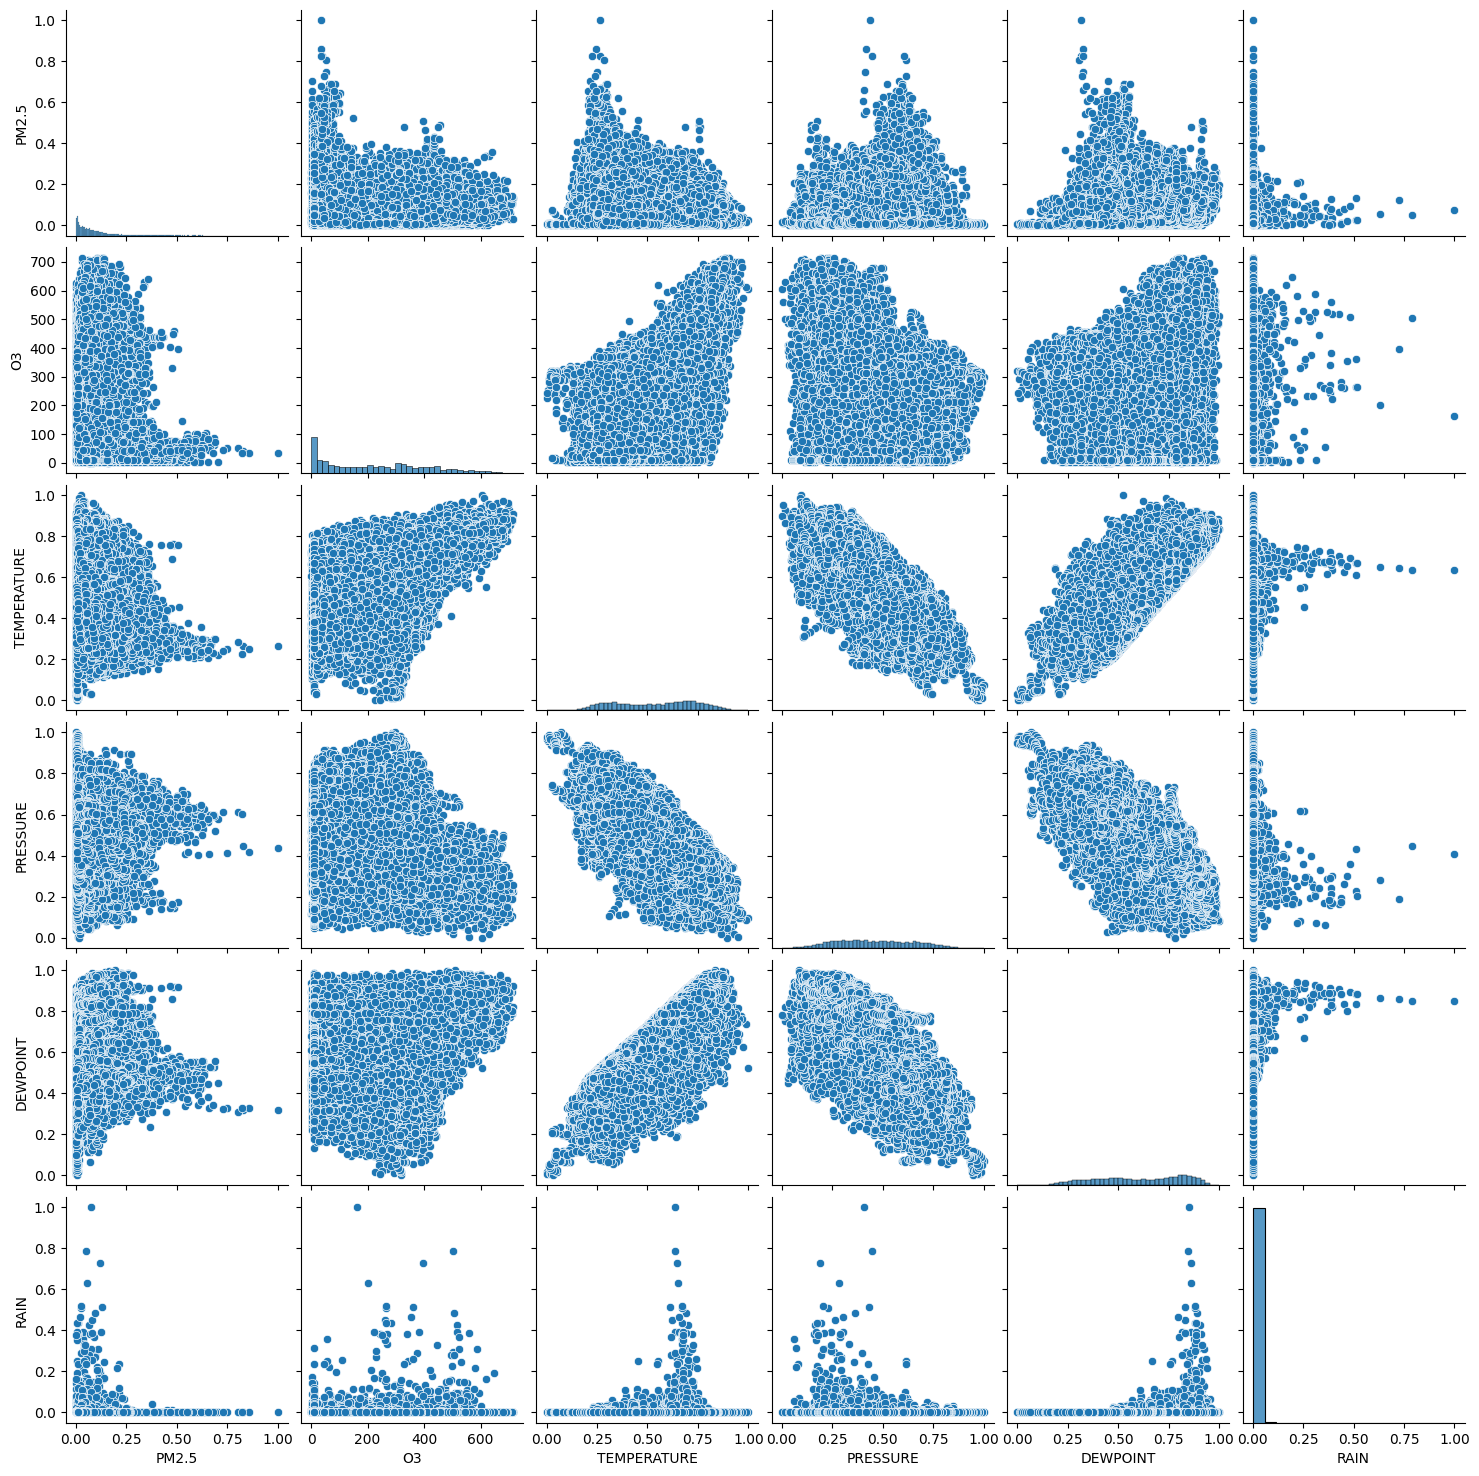

In [26]:
g = sns.pairplot(df)

<Axes: xlabel='PM2.5', ylabel='O3'>

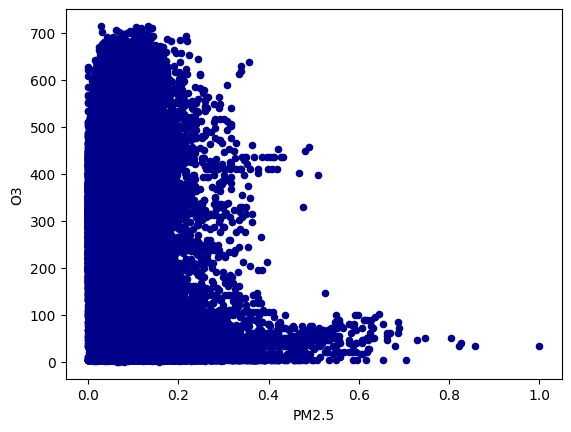

In [27]:
df.plot.scatter(x='PM2.5', y='O3', c='DarkBlue')

1052/1052 [==============================] - 2s 2ms/step


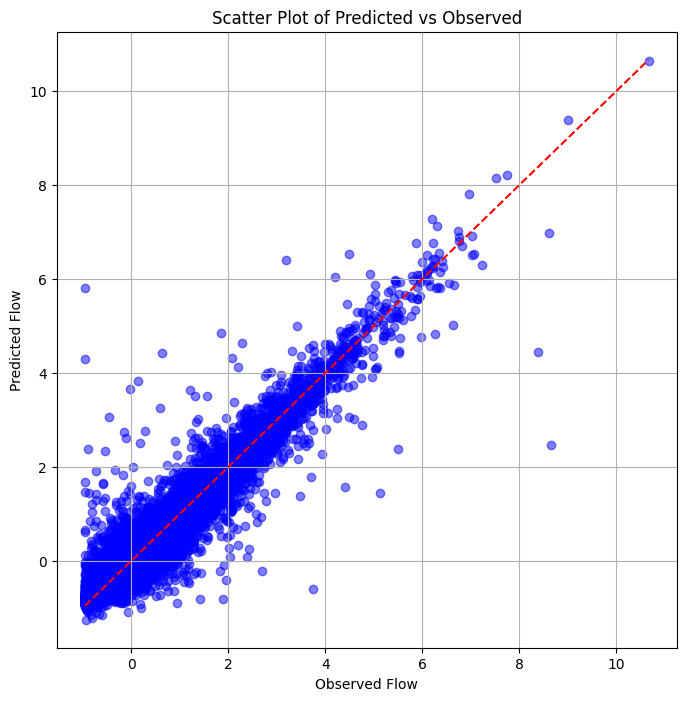

In [28]:
import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = Y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('Scatter Plot of Predicted vs Observed')
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow')
plt.grid(True)
plt.show()

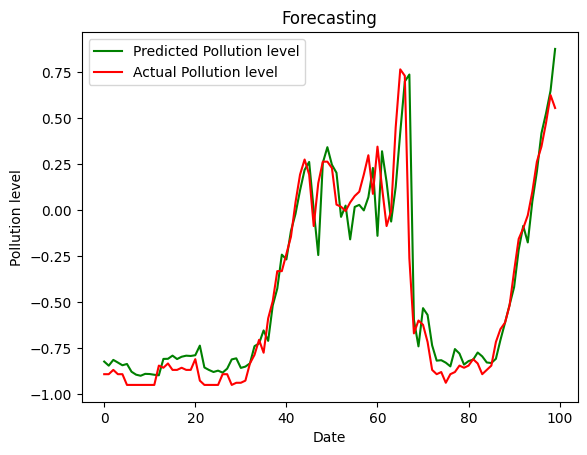

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

# Check if y_pred and y_test are 1D or 2D arrays
if len(y_pred.shape) == 2:  # If they are 2D arrays
    plt.plot(y_pred[:100, 0], color='green', label='Predicted Pollution level')  # First feature/column
    plt.plot(Y_test[:100, 0], color='red', label='Actual Pollution level')  # First feature/column
else:  # If they are 1D arrays
    plt.plot(y_pred[:100], color='green', label='Predicted Pollution level')
    plt.plot(Y_test[:100], color='red', label='Actual Pollution level')

# Plot formatting
plt.title("Forecasting")
plt.xlabel("Date")
plt.ylabel("Pollution level")
plt.legend()
plt.show()


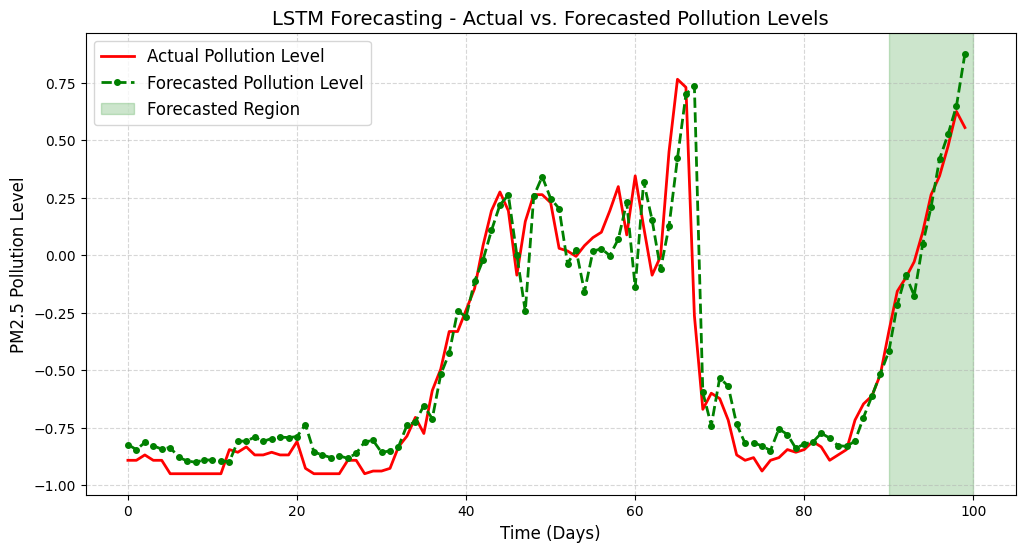

In [32]:
import matplotlib.pyplot as plt

# Increase figure size
plt.figure(figsize=(12, 6))

# Plot actual and predicted values with improved styling
plt.plot(Y_test[:100], color='red', linestyle='solid', linewidth=2, label='Actual Pollution Level')
plt.plot(y_pred[:100], color='green', linestyle='dashed', linewidth=2, marker='o', markersize=4, label='Forecasted Pollution Level')

# Highlight future prediction area
plt.axvspan(len(Y_test[:90]), len(Y_test[:100]), color='green', alpha=0.2, label="Forecasted Region")

# Improve labels and title
plt.title("LSTM Forecasting - Actual vs. Forecasted Pollution Levels", fontsize=14)
plt.xlabel("Time (Days)", fontsize=12)
plt.ylabel("PM2.5 Pollution Level", fontsize=12)

# Add grid for readability
plt.grid(True, linestyle='--', alpha=0.5)

# Adjust legend position
plt.legend(loc='upper left', fontsize=12)

# Save the improved plot
# plt.savefig('improved_graph.png', dpi=300)

# Show the plot
plt.show()

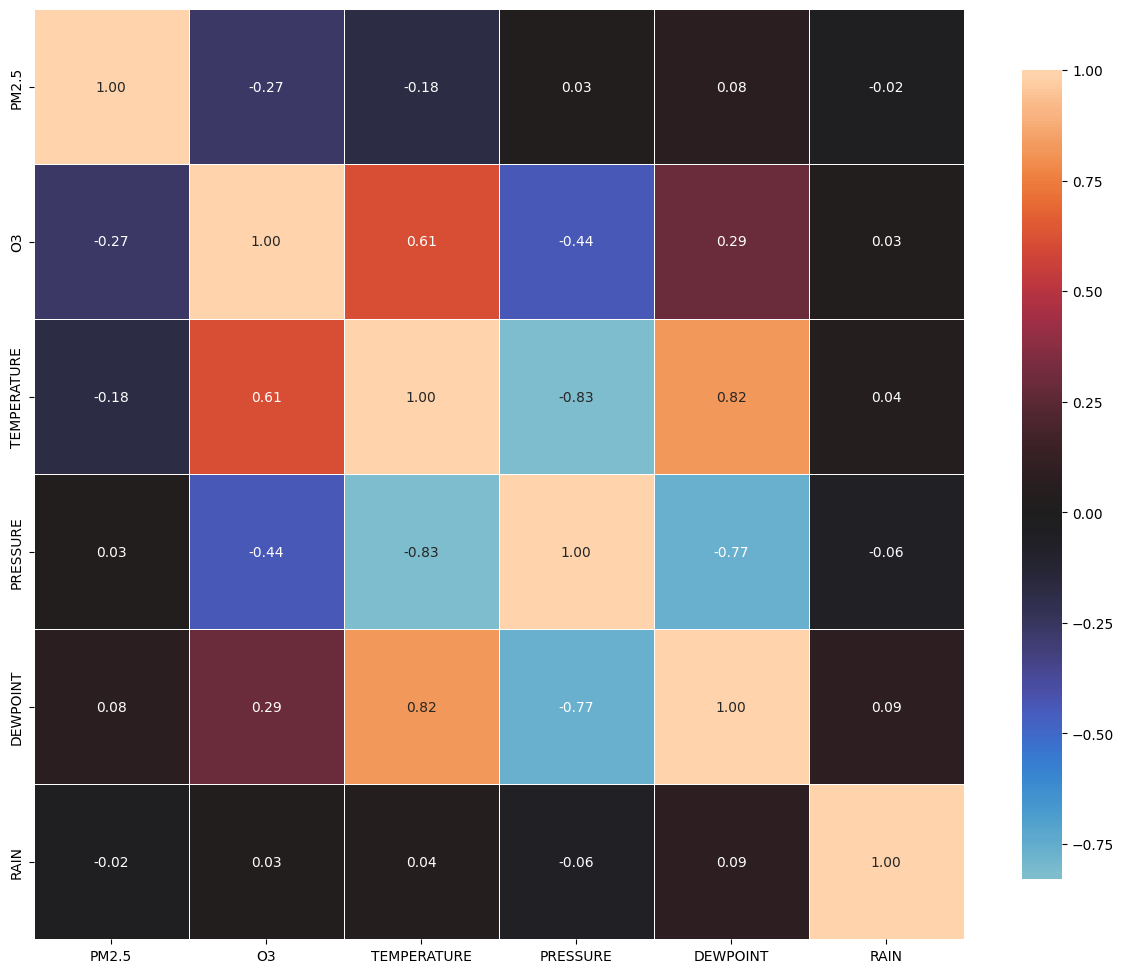

In [33]:
correlations = df.corr()
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70})
plt.show();